# HLCV Project: Self-Supervised Anomaly Detection in Medical Imaging
# Aligned with proposal goals: Tumor/Lesion detection using SSL

In [ ]:
# ======================
# 0. Setup & Data Download
# ======================
!pip install -q kaggle albumentations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import shutil
from google.colab import files, drive

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Setup Kaggle
os.makedirs("/root/.kaggle", exist_ok=True)
uploaded = files.upload()
for fn in uploaded.keys():
    shutil.move(fn, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

Using device: cuda


Saving kaggle.json to kaggle.json


In [ ]:
# Download NIH sample dataset
!kaggle datasets download -d nih-chest-xrays/sample -p /content/data
!unzip -q /content/data/sample.zip -d /content/drive/MyDrive/HLCV_ANOMALY_DETECTION



Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
User cancelled operation
replace /content/drive/MyDrive/HLCV_ANOMALY_DETECTION/sample/images/00000013_005.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/HLCV_ANOMALY_DETECTION/nih_sample/sample/sample_labels.csv'

In [ ]:
drive_path = '/content/drive/MyDrive/HLCV_ANOMALY_DETECTION'
image_dir = f'{drive_path}/sample/images'
csv_path = f'{drive_path}/sample/sample_labels.csv'
print(f"Images: {len(os.listdir(image_dir))}, CSV records: {len(pd.read_csv(csv_path))}")

Images: 5606, CSV records: 5606


In [ ]:
# ======================
# 1. Self-Supervised Learning (SimCLR)
# ======================
# SSL Transformations
ssl_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class SSLMedicalDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform or ssl_transform

    def __len__(self):
        return min(5000, len(self.df))  # Use subset for efficiency

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), self.transform(img)

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', projection_dim=256):
        super().__init__()
        self.encoder = torch.hub.load('pytorch/vision', base_model, pretrained=False)
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.projector(features)

def nt_xent_loss(z1, z2, temperature=0.1):
    z = torch.cat([z1, z2], dim=0)
    z = nn.functional.normalize(z, dim=1)
    similarity = torch.mm(z, z.t()) / temperature
    batch_size = z1.size(0)

    # Create mask for positives and negatives
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=device)
    positives = similarity[mask].view(2*batch_size, -1)[:, 0:1]
    negatives = similarity[~mask].view(2*batch_size, -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(2*batch_size, dtype=torch.long, device=device)
    return nn.CrossEntropyLoss()(logits, labels)

# SSL Training
ssl_dataset = SSLMedicalDataset(image_dir, csv_path)
ssl_loader = DataLoader(ssl_dataset, batch_size=128, shuffle=True, num_workers=2)

ssl_model = SimCLRModel().to(device)
ssl_optimizer = optim.AdamW(ssl_model.parameters(), lr=1e-3, weight_decay=1e-6)

print("\n=== SSL Pre-training ===")
for epoch in range(15):
    total_loss = 0
    ssl_model.train()
    pbar = tqdm(ssl_loader, desc=f"Epoch {epoch+1}/15")
    for (x1, x2) in pbar:
        x1, x2 = x1.to(device), x2.to(device)

        z1 = ssl_model(x1)
        z2 = ssl_model(x2)
        loss = nt_xent_loss(z1, z2)

        ssl_optimizer.zero_grad()
        loss.backward()
        ssl_optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(ssl_loader):.4f}")

# Save SSL encoder
ssl_encoder_path = f"{drive_path}/ssl_encoder.pth"
torch.save(ssl_model.encoder.state_dict(), ssl_encoder_path)
print(f"SSL encoder saved to {ssl_encoder_path}")

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== SSL Pre-training ===


Epoch 1/15: 100%|██████████| 40/40 [01:57<00:00,  2.95s/it, loss=0.0393]


Epoch 1 | Loss: 1.2078


Epoch 2/15: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it, loss=0.00189]


Epoch 2 | Loss: 0.1442


Epoch 3/15: 100%|██████████| 40/40 [01:55<00:00,  2.89s/it, loss=0.00254]


Epoch 3 | Loss: 0.0903


Epoch 4/15: 100%|██████████| 40/40 [01:56<00:00,  2.91s/it, loss=0.00312]


Epoch 4 | Loss: 0.0686


Epoch 5/15: 100%|██████████| 40/40 [01:58<00:00,  2.96s/it, loss=0.00123]


Epoch 5 | Loss: 0.0541


Epoch 6/15: 100%|██████████| 40/40 [01:59<00:00,  2.98s/it, loss=0.00144]


Epoch 6 | Loss: 0.0532


Epoch 7/15: 100%|██████████| 40/40 [01:55<00:00,  2.88s/it, loss=0.00132]


Epoch 7 | Loss: 0.0444


Epoch 8/15: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it, loss=0.00116]


Epoch 8 | Loss: 0.0391


Epoch 9/15: 100%|██████████| 40/40 [01:58<00:00,  2.97s/it, loss=0.0012]


Epoch 9 | Loss: 0.0335


Epoch 10/15: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it, loss=0.00149]


Epoch 10 | Loss: 0.0318


Epoch 11/15: 100%|██████████| 40/40 [01:57<00:00,  2.94s/it, loss=0.00122]


Epoch 11 | Loss: 0.0296


Epoch 12/15: 100%|██████████| 40/40 [01:56<00:00,  2.92s/it, loss=0.0017]


Epoch 12 | Loss: 0.0284


Epoch 13/15: 100%|██████████| 40/40 [01:55<00:00,  2.89s/it, loss=0.00108]


Epoch 13 | Loss: 0.0263


Epoch 14/15: 100%|██████████| 40/40 [01:56<00:00,  2.90s/it, loss=0.00126]


Epoch 14 | Loss: 0.0260


Epoch 15/15: 100%|██████████| 40/40 [01:56<00:00,  2.90s/it, loss=0.000961]


Epoch 15 | Loss: 0.0264
SSL encoder saved to /content/drive/MyDrive/HLCV_ANOMALY_DETECTION/ssl_encoder.pth


In [ ]:
# ======================
# 2. Tumor Detection Model (Fixed Version)
# ======================
# Tumor Augmentations
tumor_aug = A.Compose([
    A.RandomGamma(gamma_limit=(80, 120)),  # Enhance tumor visibility
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CLAHE(p=0.3),
    A.GridDistortion(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    ToTensorV2()
])

class TumorDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None, tumor_aug=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.tumor_aug = tumor_aug
        self.targets = ['Mass', 'Nodule']
        self.labels = self.df['Finding Labels'].apply(
            lambda x: int(any(t in x for t in self.targets)))
        print(f"Tumor ratio: {sum(self.labels)}/{len(self.df)} ({sum(self.labels)/len(self.df):.1%})")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Apply tumor-specific augmentations
        if label == 1 and self.tumor_aug and np.random.rand() > 0.7:
            img = np.array(img)
            augmented = self.tumor_aug(image=img)
            img = augmented['image']  # This is already a tensor from ToTensorV2
        elif self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

# Data transforms
train_transform = T.Compose([
    T.Resize(256),  # First resize to larger size
    T.RandomCrop(224),  # Then crop to final size
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_ds = TumorDataset(image_dir, csv_path, train_transform, tumor_aug)
val_ds = TumorDataset(image_dir, csv_path, val_transform)

# Handle class imbalance
train_labels = [int(label) for _, label in train_ds]
class_counts = np.bincount(train_labels, minlength=2)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

def collate_fn(batch):
    images, labels = zip(*batch)

    # Stack images ensuring same size
    images = torch.stack([img if img.size() == torch.Size([3, 224, 224])
                         else T.functional.resize(img, [224, 224])
                         for img in images])

    labels = torch.stack(labels)
    return images, labels

# Update your DataLoader creation:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    sampler=sampler,
    num_workers=2,
    collate_fn=collate_fn  # Add this line
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=2
)

/tmp/ipython-input-39-3675783512.py:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Tumor ratio: 553/5606 (9.9%)
Tumor ratio: 553/5606 (9.9%)


In [ ]:
# hehehehehhehehe

In [ ]:
# Tumor Detection Model
class TumorDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None, tumor_aug=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.tumor_aug = tumor_aug
        self.targets = ['Mass', 'Nodule']
        self.labels = self.df['Finding Labels'].apply(
            lambda x: int(any(t in x for t in self.targets)))
        print(f"Tumor ratio: {sum(self.labels)}/{len(self.df)} ({sum(self.labels)/len(self.df):.1%})")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # First resize all images to consistent size
        img = T.Resize(256)(img)

        # Apply tumor-specific augmentations
        if label == 1 and self.tumor_aug and np.random.rand() > 0.7:
            img = np.array(img)
            augmented = self.tumor_aug(image=img)
            img = augmented['image']  # This is already a tensor from ToTensorV2
        elif self.transform:
            img = self.transform(img)

        # Ensure final size is consistent (224x224)
        if isinstance(img, torch.Tensor):
            if img.shape[-2:] != torch.Size([224, 224]):
                img = T.functional.resize(img, [224, 224])
        else:
            img = T.functional.resize(img, [224, 224])

        return img, torch.tensor(label, dtype=torch.float32)

# Initialize model
base_encoder = torch.hub.load('pytorch/vision', 'resnet18', pretrained=False)
base_encoder.fc = nn.Identity()

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
try:
    base_encoder.load_state_dict(torch.load(ssl_encoder_path))
    print("Loaded SSL-pretrained encoder")
except:
    print("Using random initialization")

model = TumorDetector(base_encoder).to(device)

Loaded SSL-pretrained encoder


In [ ]:
# Loss and optimizer
pos_weight = torch.tensor([class_weights[1]/class_weights[0]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

In [ ]:
# ======================
# 3. Training & Evaluation
# ======================
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_preds.extend(probs)
            all_labels.extend(labels.numpy())

    preds = np.array(all_preds)
    labels = np.array(all_labels)

    # Calculate metrics
    auc = roc_auc_score(labels, preds)
    preds_binary = (preds > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, preds_binary).ravel()

    return {
        'auc': auc,
        'sensitivity': tp / (tp + fn),
        'specificity': tn / (tn + fp),
        'f1': f1_score(labels, preds_binary),
        'preds': preds,
        'labels': labels
    }

print("\n=== Training Tumor Detector ===")
best_auc = 0
for epoch in range(25):
    # Progressive unfreezing
    if epoch == 5:
        model.unfreeze_layers(['layer3'])
    if epoch == 10:
        model.unfreeze_layers(['layer4'])

    # Training
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/25")
    for images, labels in pbar:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    # Evaluation
    val_metrics = evaluate(model, val_loader)
    scheduler.step(val_metrics['auc'])

    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | "
          f"AUC: {val_metrics['auc']:.4f} | Sens: {val_metrics['sensitivity']:.4f} | "
          f"Spec: {val_metrics['specificity']:.4f} | F1: {val_metrics['f1']:.4f}")

    # Save best model
    if val_metrics['auc'] > best_auc:
        best_auc = val_metrics['auc']
        best_model_path = f"{drive_path}/best_tumor_model.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved (AUC={best_auc:.4f})")

# Load best model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model with AUC={best_auc:.4f}")


=== Training Tumor Detector ===


Epoch 1/25: 100%|██████████| 88/88 [01:34<00:00,  1.07s/it, loss=1.52]


Epoch 1 | Loss: 1.5942 | AUC: 0.5489 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.5489)


Epoch 2/25: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it, loss=1.49]


Epoch 2 | Loss: 1.4864 | AUC: 0.5716 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.5716)


Epoch 3/25: 100%|██████████| 88/88 [01:36<00:00,  1.09s/it, loss=1.39]


Epoch 3 | Loss: 1.4691 | AUC: 0.5756 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.5756)


Epoch 4/25: 100%|██████████| 88/88 [01:37<00:00,  1.10s/it, loss=1.21]


Epoch 4 | Loss: 1.4608 | AUC: 0.5929 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.5929)


Epoch 5/25: 100%|██████████| 88/88 [01:36<00:00,  1.10s/it, loss=1.5]


Epoch 5 | Loss: 1.4610 | AUC: 0.5835 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 6/25: 100%|██████████| 88/88 [01:37<00:00,  1.11s/it, loss=1.51]


Epoch 6 | Loss: 1.4698 | AUC: 0.6035 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6035)


Epoch 7/25: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it, loss=1.55]


Epoch 7 | Loss: 1.4588 | AUC: 0.5970 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 8/25: 100%|██████████| 88/88 [01:32<00:00,  1.05s/it, loss=1.54]


Epoch 8 | Loss: 1.4784 | AUC: 0.6032 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 9/25: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it, loss=1.4]


Epoch 9 | Loss: 1.4589 | AUC: 0.6112 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6112)


Epoch 10/25: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it, loss=1.58]


Epoch 10 | Loss: 1.4533 | AUC: 0.5980 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 11/25: 100%|██████████| 88/88 [01:34<00:00,  1.07s/it, loss=1.53]


Epoch 11 | Loss: 1.4735 | AUC: 0.6261 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6261)


Epoch 12/25: 100%|██████████| 88/88 [01:34<00:00,  1.08s/it, loss=1.44]


Epoch 12 | Loss: 1.4609 | AUC: 0.6256 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 13/25: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it, loss=1.38]


Epoch 13 | Loss: 1.4592 | AUC: 0.6373 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6373)


Epoch 14/25: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it, loss=1.57]


Epoch 14 | Loss: 1.4670 | AUC: 0.6310 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 15/25: 100%|██████████| 88/88 [01:37<00:00,  1.11s/it, loss=1.52]


Epoch 15 | Loss: 1.4357 | AUC: 0.6252 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 16/25: 100%|██████████| 88/88 [01:37<00:00,  1.11s/it, loss=1.45]


Epoch 16 | Loss: 1.4540 | AUC: 0.6258 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 17/25: 100%|██████████| 88/88 [01:37<00:00,  1.10s/it, loss=1.4]


Epoch 17 | Loss: 1.4389 | AUC: 0.6397 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6397)


Epoch 18/25: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it, loss=1.71]


Epoch 18 | Loss: 1.4501 | AUC: 0.6398 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6398)


Epoch 19/25: 100%|██████████| 88/88 [01:38<00:00,  1.12s/it, loss=1.27]


Epoch 19 | Loss: 1.4549 | AUC: 0.6182 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 20/25: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it, loss=1.42]


Epoch 20 | Loss: 1.4543 | AUC: 0.6507 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796
New best model saved (AUC=0.6507)


Epoch 21/25: 100%|██████████| 88/88 [01:37<00:00,  1.11s/it, loss=1.63]


Epoch 21 | Loss: 1.4385 | AUC: 0.6399 | Sens: 1.0000 | Spec: 0.0004 | F1: 0.1796


Epoch 22/25: 100%|██████████| 88/88 [01:36<00:00,  1.10s/it, loss=1.38]


Epoch 22 | Loss: 1.4476 | AUC: 0.6293 | Sens: 1.0000 | Spec: 0.0000 | F1: 0.1796


Epoch 23/25: 100%|██████████| 88/88 [01:33<00:00,  1.07s/it, loss=1.63]


Epoch 23 | Loss: 1.4364 | AUC: 0.6363 | Sens: 1.0000 | Spec: 0.0016 | F1: 0.1798


Epoch 24/25: 100%|██████████| 88/88 [01:36<00:00,  1.10s/it, loss=1.23]


Epoch 24 | Loss: 1.4371 | AUC: 0.6391 | Sens: 1.0000 | Spec: 0.0014 | F1: 0.1798


Epoch 25/25: 100%|██████████| 88/88 [01:37<00:00,  1.11s/it, loss=1.3]


Epoch 25 | Loss: 1.4260 | AUC: 0.6455 | Sens: 1.0000 | Spec: 0.0028 | F1: 0.1800
Loaded best model with AUC=0.6507


In [ ]:
# Final evaluation
final_metrics = evaluate(model, val_loader)
print("\n=== Final Metrics ===")
print(f"AUC: {final_metrics['auc']:.4f}")
print(f"Sensitivity: {final_metrics['sensitivity']:.4f}")
print(f"Specificity: {final_metrics['specificity']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")


=== Final Metrics ===
AUC: 0.6507
Sensitivity: 1.0000
Specificity: 0.0000
F1 Score: 0.1796



=== Results Visualization ===


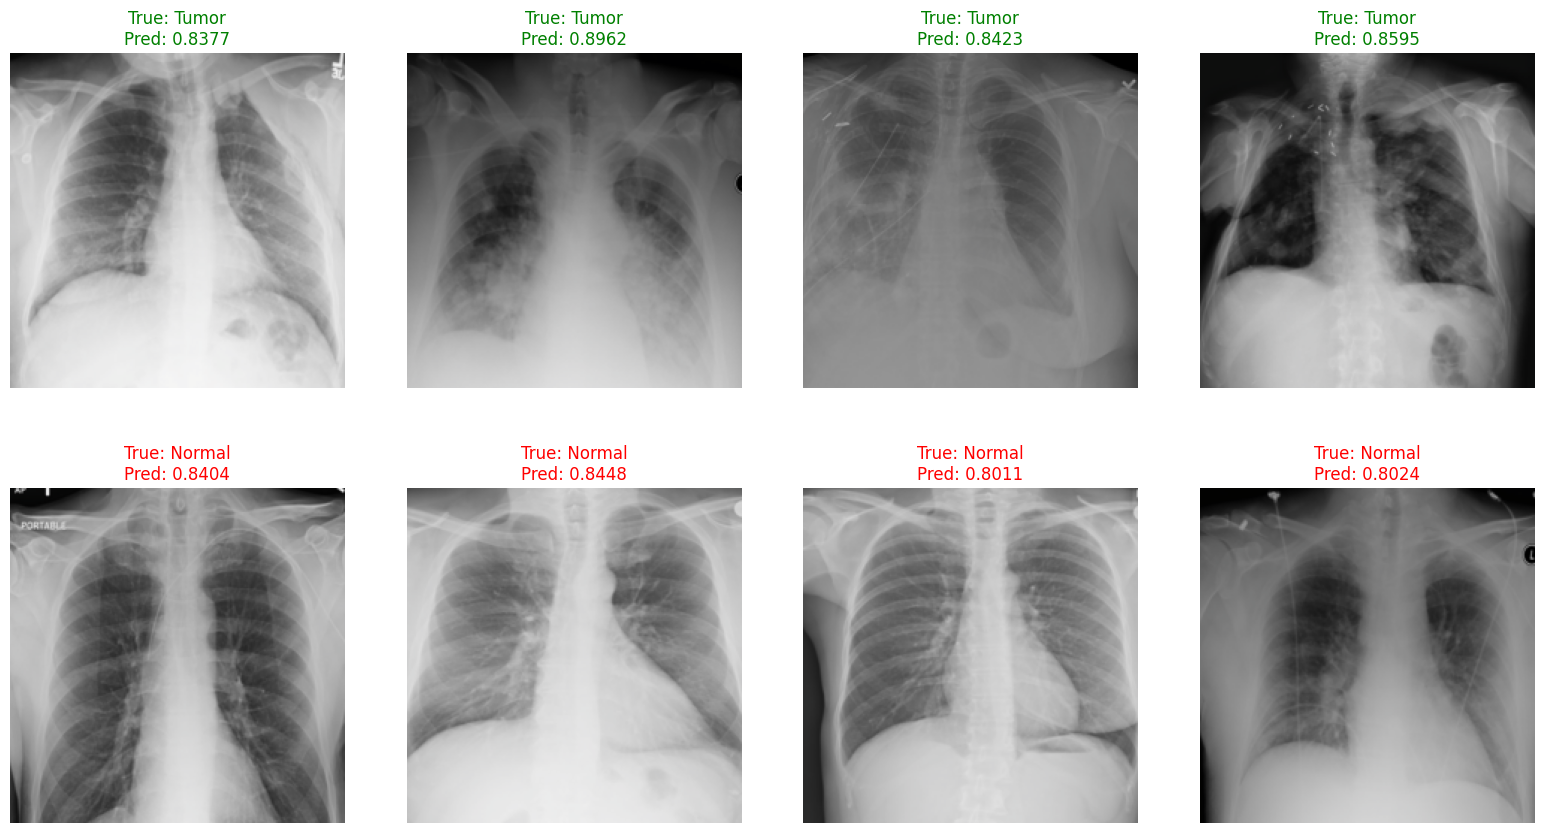

All results saved to Google Drive


In [ ]:
# ======================
# 4. Visualization
# ======================
def visualize_results(model, dataset, n=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    # Collect samples (4 tumors + 4 normals)
    tumor_idxs = [i for i, (_, label) in enumerate(dataset) if label == 1]
    normal_idxs = [i for i, (_, label) in enumerate(dataset) if label == 0]
    selected_idxs = np.random.choice(tumor_idxs, 4, replace=False).tolist() + np.random.choice(normal_idxs, 4, replace=False).tolist()

    for i, idx in enumerate(selected_idxs):
        img, true_label = dataset[idx]

        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            prob = torch.sigmoid(output).item()

        # Denormalize
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax = axes[i//4, i%4]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {'Tumor' if true_label else 'Normal'}\nPred: {prob:.4f}",
                    color='green' if (prob > 0.5) == (true_label==1) else 'red')
        ax.axis('off')

    plt.savefig(f"{drive_path}/results.png")
    plt.show()

print("\n=== Results Visualization ===")
visualize_results(model, val_ds)

print("All results saved to Google Drive")

In [47]:
# Saving the best model (from your code)
best_model_path = f"{drive_path}/best_tumor_model.pth"
torch.save(model.state_dict(), best_model_path)
print(f"New best model saved (AUC={best_auc:.4f})")

New best model saved (AUC=0.6507)


In [48]:
!ls -l "{drive_path}"

total 89064
-rw-r--r-- 1 root root 45452203 Jul 15 20:18 best_tumor_model.pth
drwxr-xr-x 3 root root     4096 Jul 15 16:29 data
-rw-r--r-- 1 root root   516866 Jul 15 20:07 results.png
drwxr-xr-x 4 root root     4096 Jul 15 17:13 sample
-rw-r--r-- 1 root root   432125 Sep 21  2019 sample_labels.csv
-rw-r--r-- 1 root root 44784754 Jul 15 17:54 ssl_encoder.pth


In [49]:
print(drive_path)

/content/drive/MyDrive/HLCV_ANOMALY_DETECTION
